# The histogram of oriented gradients (HOG)

Histogram of Oriented Gradients (HOG) is a feature descriptor technique widely used in computer vision and image processing for object detection. It focuses on capturing the local object shape and appearance by analyzing the distribution of oriented gradients.

HOG Steps:
- Preprocessing:
  - Grayscale Conversion: Convert the image to grayscale. Color information can be distracting for HOG, as it focuses on shape.
  - Resizing: Resize the image to a standard size, typically 64 x 128 pixels. This ensures consistency and reduces computational complexity.
- Gradient Calculation: For each pixel in the image, calculate the gradient in the x and y directions using filters like Sobel filters. This captures the intensity changes, essentially finding edges.
- Orientation and Magnitude: Calculate the magnitude of the gradient at each pixel. Determine the orientation of the gradient, typically using arctangent.
- Cell Division: Divide the image into small rectangular regions called cells 8 * 8 pixels. This localizes the features extracted by HOG.
- Histogram Construction: Within each cell, create a histogram with 9 bins . The histogram counts the occurrences of gradients falling into each bin based on their calculated orientation. Essentially, it captures the distribution of edge orientations within a local area.
- Block Normalization: Group multiple cells into larger regions called blocks. To account for illumination variations, normalize the histograms within each block. This reduces the influence of lighting on the feature vector. Common methods include L1 or L2-norm normalization.
- Feature Vector: Concatenate the normalized histograms from all blocks to form a single feature vector. This vector represents the overall distribution of oriented gradients in the image, capturing the local shape information of the object.

## Conecting To the Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Importing Libreries

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

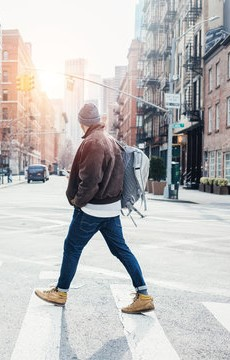

In [ ]:
image_path = '/content/drive/MyDrive/medical_imaging/hog.jpg'
image = cv2.imread(image_path)
cv2_imshow(image)

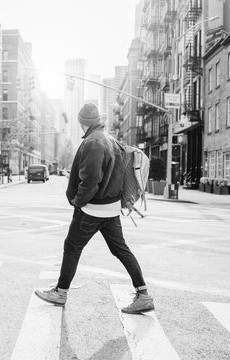

In [ ]:
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

cv2_imshow(gray_image)

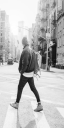

In [ ]:
resize=(64, 128)
gray_image = cv2.resize(gray_image, dsize=resize, interpolation=cv2.INTER_AREA)
cv2_imshow(gray_image)

In [ ]:
def calculate_gradients(image):
  dx = np.array([-1, 0, 1])
  # dy = np.array([[1],[0],[-1]])
  dy = np.array([1,0,-1])

  image_height, image_width = image.shape

  gx = np.zeros_like(image)
  gy = np.zeros_like(image)

  padded_image = np.pad(image, ((1, 1), (1, 1)), mode='edge')

  for y in range(1, image_height + 1):
    for x in range(1, image_width + 1):
      gx[y - 1, x - 1] = np.sum(padded_image[y - 1:y + 1 + 1, x] * dx)
      gy[y - 1, x - 1] = np.sum(padded_image[y, x - 1:x + 1 + 1] * dy)

  return gx, gy

In [ ]:
def calculate_magnitude_orientation(gx, gy):
  # Calculate magnitude (don't divide by zero)
  with np.errstate(divide='ignore', invalid='ignore'):
    magnitude = np.sqrt(np.square(gx) + np.square(gy))
    magnitude[magnitude == 0] = 1

  # Calculate orientation in degrees its in gradian
  orientation = np.arctan2(gy, gx) * 180 / np.pi

  # make orientation in the range(0, 180)
  orientation = (orientation + 180) % 180

  return magnitude, orientation

In [ ]:
def extract_features(magnitude, orientation, cell_size, block_size, n_bins):
  image_height, image_width = magnitude.shape
  cell_height, cell_width = cell_size
  block_height, block_width = block_size

  # Calculate number of cells and blocks in the image
  n_cells_h = image_height // cell_height
  n_cells_w = image_width // cell_width
  n_blocks_height = 15
  n_blocks_width = 7
  features = []

  for i in range(n_blocks_height):
    for j in range(n_blocks_width):
      block_magnitude = magnitude[i * 8 : i * 8 + 16, j * 8 : j * 8 + 16]
      block_orientation = orientation[i * 8 : i * 8 + 16, j * 8 : j * 8 + 16]
      block_features = []

      for cell_row in range(2):
        for cell_col in range(2):
            cell_magnitude = block_magnitude[cell_row * 8: (cell_row + 1) * 8, cell_col * 8: (cell_col + 1) * 8]
            cell_orientation = block_orientation[cell_row * 8: (cell_row + 1) * 8, cell_col * 8: (cell_col + 1) * 8]
            # Calculate histogram for each cell
            cell_histogram, _ = np.histogram(cell_orientation, bins=n_bins, weights=cell_magnitude)

            block_features.extend(cell_histogram)

      block_features /= np.sqrt(np.sum(np.square(block_features)) + 1e-6)
      features.extend(block_features)


  return features

In [ ]:
def hog(image):
  cell_size=(8, 8)
  block_size=(16,16)
  n_bins=9
  gx, gy = calculate_gradients(gray_image)

  # Calculate magnitude and orientation
  magnitude, orientation = calculate_magnitude_orientation(gx, gy)

  # Create histograms for each cell
  features = extract_features(magnitude, orientation, cell_size, block_size, n_bins)

  return features

## display the size of the outputed features vector

In [ ]:
features = hog(gray_image)

<ipython-input-108-2a3724f20320>:28: RuntimeWarning: overflow encountered in square
  block_features /= np.sqrt(np.sum(np.square(block_features)) + 1e-6)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


In [ ]:
print(len(features))

3780
